<a href="https://colab.research.google.com/github/ayushjain94/testayush/blob/master/Copy_of_ECE542_Hw03a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Convolutional Neural Networks**

In this notebook, we will explore some of the basic tools for regularization and hyper-parameter tuning for neural networks.



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout

from tensorflow.keras import regularizers

from keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Load and Splitting Data

We Will make use of the CIFAR10 dataset.

In [2]:
# Loading train and test dataset
(trainingX, trainingY), (testX, testY) = cifar10.load_data()
labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

# Keeping 20% for Validation
valid_set_pc = 0.2
split= int((len(trainingX))*(1-valid_set_pc))

validX = trainingX[split:]
validY = trainingY[split:]

trainX = trainingX[:split]
trainY = trainingY[:split]

170500096/170498071 [==============================] - 6s 0us/step


ship


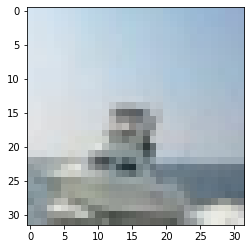

In [3]:
# Showing a samples from the dataset
sampleID = 100
plt.imshow(trainX[sampleID])
print(labels[trainY[sampleID][0]])

In [4]:
# Convert from integers to floats
trainingX = trainingX.astype('float32')
trainX = trainX.astype('float32')
validX = validX.astype('float32')
testX  = testX.astype('float32')

# Normalize to range 0-1
trainingX = trainingX / 255.0
trainX = trainX / 255.0
validX = validX / 255.0
testX  = testX / 255.0

# One-hot encoding of outputs
trainingY = to_categorical(trainingY)
trainY = to_categorical(trainY)
validY = to_categorical(validY)
testY  = to_categorical(testY)

## Training a Base CNN Model

In [5]:
# Defining Base CNN Model
def define_base_model():
	model = Sequential()
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
	model.add(MaxPooling2D((2, 2)))
 
	model.add(Flatten())
	model.add(Dense(1024, activation='relu'))
	model.add(Dense(10, activation='softmax'))
 
	return model

# Creating an instance
base_model = define_base_model()
base_model.summary()
base_model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [6]:
# Training base model
base_history = base_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 2.0361 - accuracy: 0.2603 - val_loss: 1.7976 - val_accuracy: 0.3525
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.6581 - accuracy: 0.4068 - val_loss: 1.6597 - val_accuracy: 0.4165
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4645 - accuracy: 0.4793 - val_loss: 1.4057 - val_accuracy: 0.4997
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3473 - accuracy: 0.5208 - val_loss: 1.2865 - val_accuracy: 0.5535
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2417 - accuracy: 0.5577 - val_loss: 1.2278 - val_accuracy: 0.5739
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1451 - accuracy: 0.5963 - val_loss: 1.2063 - val_accuracy: 0.5741
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0589 - accuracy: 0.6275 - val_loss: 1.0603 - val_accuracy:

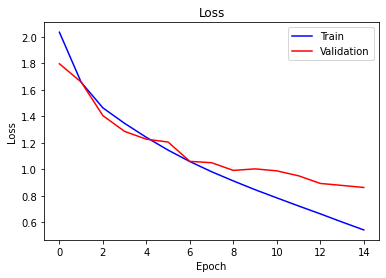

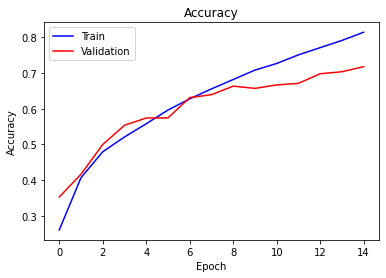

In [7]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
    
    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()
  
plot_history(base_history)

# **[Task 1] Comparing Optimizers**

The goal of of this section is to compare the performance of various optimizers: SGD with momentum, RMS Prop and Adam. Make sure you complete the following steps:

1. Train the network with SGB with momentum
2. Train the network with RMS Prop
3. Train the network with Adam
4. Create two plots showing accuracy for the training and validation sets
5. Comment on the performance of each optimizer. Which one had the steepest learning curve? Which one gave the final best performance? 




Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7818 - accuracy: 0.3538 - val_loss: 1.4638 - val_accuracy: 0.4693
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3332 - accuracy: 0.5217 - val_loss: 1.2162 - val_accuracy: 0.5665
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1064 - accuracy: 0.6083 - val_loss: 1.0530 - val_accuracy: 0.6360
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9274 - accuracy: 0.6751 - val_loss: 0.9361 - val_accuracy: 0.6741
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7961 - accuracy: 0.7227 - val_loss: 0.8624 - val_accuracy: 0.7009
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6725 - accuracy: 0.7653 - val_loss: 0.8547 - val_accuracy: 0.7110
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5575 - accuracy: 0.8088 - val_loss: 0.8357 - val_accuracy:

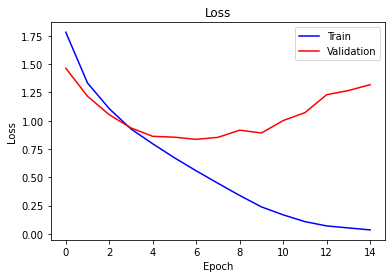

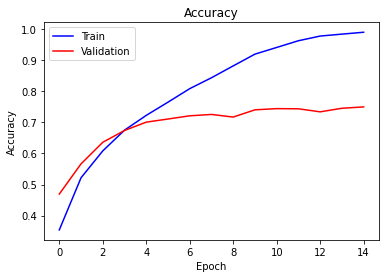

In [8]:
# TODO - Training model with momentum 
base_sgd_model = define_base_model()
optimizer = SGD(momentum=0.7)
base_sgd_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
base_sgd_model_history = base_sgd_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)
plot_history(base_sgd_model_history)

Epoch 1/15
1250/1250 [==============================] - 7s 6ms/step - loss: 1.5303 - accuracy: 0.4559 - val_loss: 1.1867 - val_accuracy: 0.5756
Epoch 2/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0283 - accuracy: 0.6446 - val_loss: 1.0785 - val_accuracy: 0.6280
Epoch 3/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8633 - accuracy: 0.7095 - val_loss: 0.9569 - val_accuracy: 0.6840
Epoch 4/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7836 - accuracy: 0.7366 - val_loss: 0.9270 - val_accuracy: 0.7119
Epoch 5/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7359 - accuracy: 0.7549 - val_loss: 1.0910 - val_accuracy: 0.6594
Epoch 6/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.7051 - accuracy: 0.7679 - val_loss: 1.0555 - val_accuracy: 0.6729
Epoch 7/15
1250/1250 [==============================] - 7s 5ms/step - loss: 0.6849 - accuracy: 0.7750 - val_loss: 1.1627 - val_accuracy:

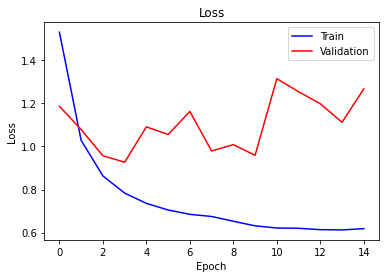

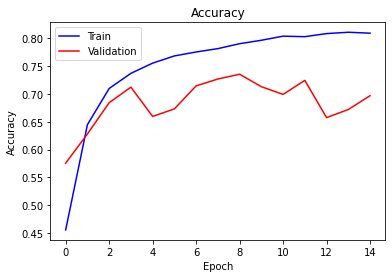

In [9]:
# TODO - Training model with RMS Prop
base_rms_model = define_base_model()
optimizer = keras.optimizers.RMSprop()
base_rms_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
base_rms_model_history = base_rms_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)
plot_history(base_rms_model_history)

Epoch 1/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4375 - accuracy: 0.4787 - val_loss: 1.1285 - val_accuracy: 0.6063
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9736 - accuracy: 0.6548 - val_loss: 0.8856 - val_accuracy: 0.6909
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7548 - accuracy: 0.7335 - val_loss: 0.8283 - val_accuracy: 0.7128
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.5885 - accuracy: 0.7962 - val_loss: 0.8162 - val_accuracy: 0.7324
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4391 - accuracy: 0.8454 - val_loss: 0.8508 - val_accuracy: 0.7331
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.3091 - accuracy: 0.8897 - val_loss: 0.9732 - val_accuracy: 0.7283
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.2093 - accuracy: 0.9273 - val_loss: 1.0581 - val_accuracy:

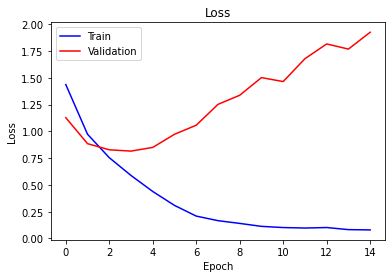

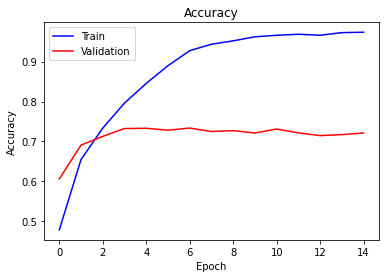

In [10]:
# TODO - Training model with Adam
base_adam_model = define_base_model()
optimizer = keras.optimizers.Adam()
base_adam_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
base_adam_model_history = base_adam_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)
plot_history(base_adam_model_history)


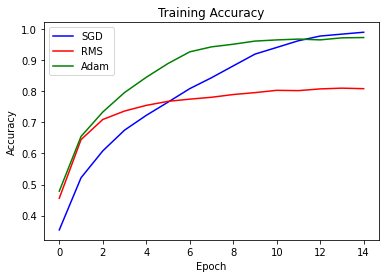

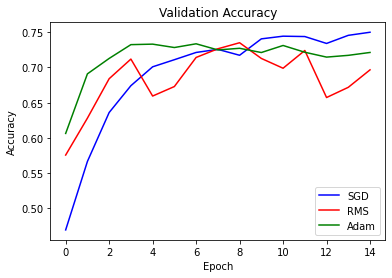

In [11]:
# TODO - Plotting training accuracy

# plot accuracy
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(base_sgd_model_history.history['accuracy'], color='blue', label='SGD')
plt.plot(base_rms_model_history.history['accuracy'], color='red', label='RMS')
plt.plot(base_adam_model_history.history['accuracy'], color='green', label='Adam')

plt.legend(['SGD','RMS','Adam'])
plt.show()

# plot validation accuracy
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(base_sgd_model_history.history['val_accuracy'], color='blue', label='SGD')
plt.plot(base_rms_model_history.history['val_accuracy'], color='red', label='RMS')
plt.plot(base_adam_model_history.history['val_accuracy'], color='green', label='Adam')

plt.legend(['SGD','RMS','Adam'])
plt.show()


# **Observations**

SGD optimizer has the best performance among the three models

# **[Task 2] Applying Standard Regularization**

The goal of this section is to compare the effect of different normalization approaches including Batch normalization and Dropout. Make sure to complete the following steps:

1. Create a new model by adding a batch normalization layer after each convolutional layer and between the dense layers of the base model. Train it using the Adam optimizer.
2. Create a new model by adding dropout after each convolutional layer and between the dense layers of the base model with a rate equal to $0.2$. Train it using the Adam optimizer.
3. Create two plots showing accuracy for the training and validation sets comparing the regularized versions against the base model trained with the Adam optimizer.
4. Comment on the performance of each model. Which one had the steepest learning curve? Which one gave the final best performance? 




Epoch 1/15
1250/1250 [==============================] - 7s 6ms/step - loss: 1.4082 - accuracy: 0.5238 - val_loss: 1.3015 - val_accuracy: 0.5384
Epoch 2/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.9202 - accuracy: 0.6840 - val_loss: 0.9814 - val_accuracy: 0.6641
Epoch 3/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.7142 - accuracy: 0.7523 - val_loss: 1.2356 - val_accuracy: 0.6045
Epoch 4/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.5467 - accuracy: 0.8099 - val_loss: 1.6813 - val_accuracy: 0.5498
Epoch 5/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.4163 - accuracy: 0.8553 - val_loss: 0.9820 - val_accuracy: 0.7031
Epoch 6/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.3109 - accuracy: 0.8918 - val_loss: 0.8944 - val_accuracy: 0.7392
Epoch 7/15
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2236 - accuracy: 0.9224 - val_loss: 1.0817 - val_accuracy:

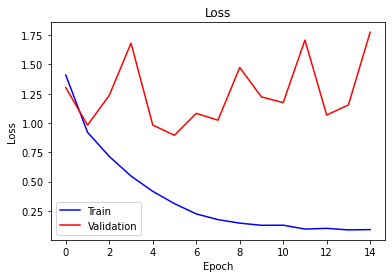

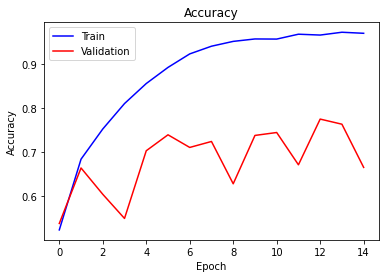

In [12]:
# TODO - Defining Batch Normalization model and training it
def define_batch_normalization_model():
    model = Sequential()
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
  
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
  
    return model

# TODO - Training model with Adam
batch_normalization_model = define_batch_normalization_model()
optimizer = keras.optimizers.Adam()
batch_normalization_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
batch_normalization_model_history = batch_normalization_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)
plot_history(batch_normalization_model_history)


Epoch 1/15
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5392 - accuracy: 0.4344 - val_loss: 1.2305 - val_accuracy: 0.5686
Epoch 2/15
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1358 - accuracy: 0.5953 - val_loss: 1.0461 - val_accuracy: 0.6253
Epoch 3/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9664 - accuracy: 0.6596 - val_loss: 0.9661 - val_accuracy: 0.6658
Epoch 4/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.8546 - accuracy: 0.6984 - val_loss: 0.8521 - val_accuracy: 0.7060
Epoch 5/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7774 - accuracy: 0.7278 - val_loss: 0.7735 - val_accuracy: 0.7247
Epoch 6/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.7003 - accuracy: 0.7523 - val_loss: 0.7854 - val_accuracy: 0.7344
Epoch 7/15
1250/1250 [==============================] - 6s 5ms/step - loss: 0.6468 - accuracy: 0.7714 - val_loss: 0.7423 - val_accuracy:

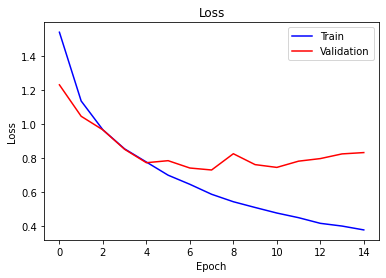

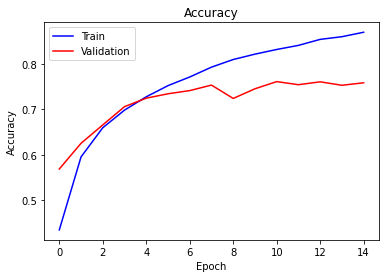

In [14]:
# TODO - Defining dropout regularized model and training it
def define_drop_out_model():
    model = Sequential()
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))
  
    return model

drop_out_model = define_drop_out_model()
optimizer = keras.optimizers.Adam()
drop_out_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
drop_out_model_history = drop_out_model.fit(trainX, trainY, epochs=15, validation_data=(validX, validY), verbose=1)
plot_history(drop_out_model_history)


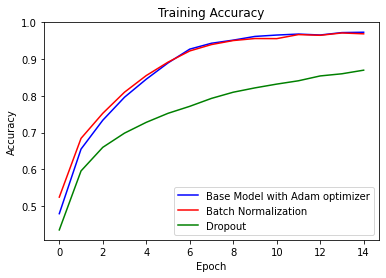

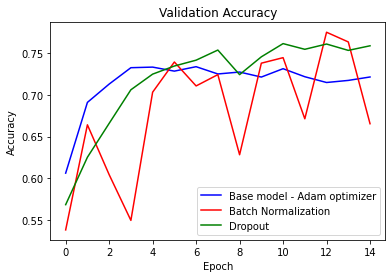

In [19]:
# TODO - Plotting training accuracy
# plot accuracy
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(base_adam_model_history.history['accuracy'], color='blue', label='Base Model')
plt.plot(batch_normalization_model_history.history['accuracy'], color='red', label='Batch Normalization')
plt.plot(drop_out_model_history.history['accuracy'], color='green', label='Dropout')

plt.legend(['Base Model with Adam optimizer','Batch Normalization','Dropout'])
plt.show()

# plot validation accuracy
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(base_adam_model_history.history['val_accuracy'], color='blue', label='Base Model - Adam')
plt.plot(batch_normalization_model_history.history['val_accuracy'], color='red', label='Batch Normalization')
plt.plot(drop_out_model_history.history['val_accuracy'], color='green', label='Dropout')

plt.legend(['Base model - Adam optimizer','Batch Normalization','Dropout'])
plt.show()


[TODO - Add your observations]

# **[Task 3] Hyperparameter Tuning**

The objective of this section is to perform hyperparameter tuning of the network using a grid search. Make sure to complete these steps:

1. Perform a grid search for the optimal hyperparameters for the model with dropout regularization and Adam optimizer using the dropout values [0.1, 0.2, 0.3] and the learning rate values [0.1, 0.01, 0.001].
2. Display the results for the best model on the test dataset.

In [28]:
# TODO - Defining final model for optimization

def define__model(learning_rate, drop_out_rate):
    model = Sequential()
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop_out_rate))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop_out_rate))
  
    model.add(Conv2D(256, (3, 3), activation='relu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(drop_out_rate))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_out_rate))
    model.add(Dense(10, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


model = KerasClassifier(build_fn=define__model, epochs=5, batch_size=10, verbose=1)
learning_rate = [0.1, 0.01, 0.001]
drop_out_rate = [0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, drop_out_rate=drop_out_rate)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

In [ ]:
# TODO - Displaying best parameters found
grid_result = grid.fit(trainingX, trainingY)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Best Score', grid_result.best_score_)
print('Best Params', grid_result.best_params_)
